### Infer local ancestry of simulated data in msprime

In [6]:
# census events example in tutorial
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import random
import collections
import msprime
import numpy as np
import seaborn as sns
import multiprocessing
import matplotlib.pyplot as plt

from IPython.display import SVG

For instance, the following code specifies a simulation with two samples drawn from each of two populations. There are two demographic events: a migration rate change and a census event. At generation 100 and earlier, the two populations exchange migrants at a rate of 0.05. At generation 5000, a census is performed:

In [8]:
pop_config = msprime.PopulationConfiguration(sample_size=2, initial_size=1000)
mig_rate_change = msprime.MigrationRateChange(time=100, rate=0.05)
ts = msprime.simulate(
            population_configurations=[pop_config, pop_config],
            length=1000,
            demographic_events=[mig_rate_change, msprime.CensusEvent(time=5000)],
            recombination_rate=1e-7,
            random_seed=141)

The resulting tree sequence has nodes on each tree at the specified census time. These are the nodes with IDs 8, 9, 10, 11, 12 and 13:

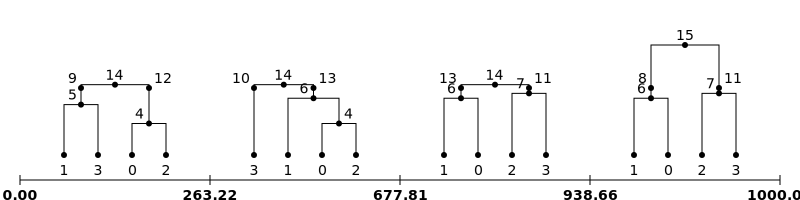

In [9]:
display(SVG(ts.draw_svg()))

This tells us that the genetic material ancestral to the present day sample was held within 5 haplotypes at time 5000. The node table shows us that four of these haplotypes (nodes 8, 9, 10 and 11) were in population 0 at this time, and two of these haplotypes (nodes 12 and 13) were in population 1 at this time.

In [8]:
print(ts.tables.nodes)

id	flags	population	individual	time	metadata
0	1	0	-1	0.00000000000000	
1	1	0	-1	0.00000000000000	
2	1	1	-1	0.00000000000000	
3	1	1	-1	0.00000000000000	
4	0	1	-1	2350.08685279051815	
5	0	1	-1	3759.20387382847684	
6	0	0	-1	4234.97992185234671	
7	0	1	-1	4598.83898042243527	
8	1048576	0	-1	5000.00000000000000	
9	1048576	0	-1	5000.00000000000000	
10	1048576	0	-1	5000.00000000000000	
11	1048576	0	-1	5000.00000000000000	
12	1048576	1	-1	5000.00000000000000	
13	1048576	1	-1	5000.00000000000000	
14	0	1	-1	5246.90282987397495	
15	0	0	-1	8206.73121309170347	


If we wish to study these ancestral haplotypes further, we can simplify the tree sequence with respect to the census nodes and perform subsequent analyses on this simplified tree sequence. In this example, ts_anc is a tree sequence obtained from the original tree sequence ts by labelling the census nodes as samples and removing all nodes and edges that are not ancestral to these census nodes.

In [9]:
nodes = [i.id for i in ts.nodes() if i.flags==msprime.NODE_IS_CEN_EVENT]
ts_anc = ts.simplify(samples=nodes)

In [12]:
#ts_anc
#display(SVG(ts_anc.draw_svg()))
print(ts_anc.tables.nodes)

id	flags	population	individual	time	metadata
0	1048577	0	-1	5000.00000000000000	
1	1048577	0	-1	5000.00000000000000	
2	1048577	0	-1	5000.00000000000000	
3	1048577	0	-1	5000.00000000000000	
4	1048577	1	-1	5000.00000000000000	
5	1048577	1	-1	5000.00000000000000	
6	0	1	-1	5246.90282987397495	
7	0	0	-1	8206.73121309170347	


### Try with my simulation

In [19]:
# try with simple model, 10mb admixed
import msprime, sys
from math import log
from math import exp
#seed = int(sys.argv[1]) # input the seed
seed = 141

mu=1.25e-8 # mutation rate per bp
rho=1e-8 # recombination rate per bp
#nbp=1e8 # generate 100Mb
nbp=1e7 # generate 10Mb
N0=7310 # initial population size
Thum=5920 # time (gens) of advent of modern humans
Naf=14474 # size of african population
Tooa=2040 # number of generations back to Out of Africa
Nb=1861 # size of out of africa population
mafb=1.5e-4 # migration rate Africa and Out-of-Afica
Teu=920 # number generations back to Asia-Euroupe split
Neu=1032; Nas=554 # bottleneck population sizes
mafeu=2.5e-5;mafas=7.8e-6;meuas=3.11e-5 #mig.rates
reu=0.0038 #growth rate per generation in Europe
ras=0.0048 #growth rate per generation in Asia
Tadmix=16 # time of admixture
Nadmix=30000 # initial size of admixed population
radmix=.05 # growth rate of admixed population

# pop0 is Africa, pop1 is Europe,  pop2 is admixed
refsamplesize=200
admsamplesize=1000 #sample size of admixted pop
pop_config = [
    msprime.PopulationConfiguration(sample_size=refsamplesize, initial_size=Naf, growth_rate=0.0),
    msprime.PopulationConfiguration(sample_size=refsamplesize, initial_size=Neu*exp(reu*Teu), growth_rate=reu),
    msprime.PopulationConfiguration(sample_size=admsamplesize, initial_size=Nadmix*exp(radmix*Tadmix), growth_rate=radmix)]
mig_mat=[
    [0,mafeu,0],
    [mafeu,0,0],
    [0,0,0]]

# Admixture event, 0.8 Africa, 0.2 Europe
admixture_event = [msprime.MassMigration(time=Tadmix, source=2, destination=0, proportion=0.8), # African came to America
                  msprime.MassMigration(time=Tadmix+0.0001, source=2, destination=1, proportion=1.0)] # European came to America

# cencus events 
cencus_event=[msprime.CensusEvent(time=20)]

# Out of Africa event
ooa_event = [
    msprime.MigrationRateChange(time=Tooa, rate=0.0),
    msprime.MassMigration(time=Tooa+0.0001, source=1, destination=0, proportion=1.0)
]

# initial population size
init_event=[msprime.PopulationParametersChange(time=Thum, initial_size=N0, population_id=0)]

#events = admixture_event + eu_event + ooa_event + init_event
#events = admixture_event + ooa_event + init_event
events = admixture_event + cencus_event +  ooa_event  + init_event

treeseq = msprime.simulate(
    population_configurations=pop_config,
    migration_matrix=mig_mat,
    demographic_events=events,
    length=nbp,
    recombination_rate=rho, 
    mutation_rate=mu,
    random_seed=seed)
#print((treeseq.num_trees, treeseq.num_sites))

In [20]:
dd = msprime.DemographyDebugger(
    population_configurations=pop_config,
    migration_matrix=mig_mat,
    demographic_events=events)
dd.print_history()

Model =  hudson(reference_size=1)
Epoch: 0 -- 16.0 generations
     start     end      growth_rate |     0        1        2    
   -------- --------       -------- | -------- -------- -------- 
0 |1.45e+04 1.45e+04              0 |     0     2.5e-05     0    
1 | 3.4e+04  3.2e+04         0.0038 |  2.5e-05     0        0    
2 |6.68e+04   3e+04            0.05 |     0        0        0    

Events @ generation 16.0
   - Mass migration: Lineages moved with probability 0.8 backwards in time with source 2 & dest 0
                     (equivalent to migration from 0 to 2 forwards in time)
Epoch: 16.0 -- 16.0001 generations
     start     end      growth_rate |     0        1        2    
   -------- --------       -------- | -------- -------- -------- 
0 |1.45e+04 1.45e+04              0 |     0     2.5e-05     0    
1 | 3.2e+04  3.2e+04         0.0038 |  2.5e-05     0        0    
2 |  3e+04    3e+04            0.05 |     0        0        0    

Events @ generation 16.0001
   - Mass mig

In [21]:
#display(SVG(treeseq.draw_svg()))
#print(treeseq.tables.nodes)
nodes = [i.id for i in treeseq.nodes() if i.flags==msprime.NODE_IS_CEN_EVENT]
ts_anc = treeseq.simplify(samples=nodes)
print(ts_anc.tables.nodes)

id	flags	population	individual	time	metadata
0	1048577	0	-1	20.00000000000000	
1	1048577	0	-1	20.00000000000000	
2	1048577	0	-1	20.00000000000000	
3	1048577	0	-1	20.00000000000000	
4	1048577	0	-1	20.00000000000000	
5	1048577	0	-1	20.00000000000000	
6	1048577	0	-1	20.00000000000000	
7	1048577	0	-1	20.00000000000000	
8	1048577	0	-1	20.00000000000000	
9	1048577	0	-1	20.00000000000000	
10	1048577	0	-1	20.00000000000000	
11	1048577	0	-1	20.00000000000000	
12	1048577	0	-1	20.00000000000000	
13	1048577	0	-1	20.00000000000000	
14	1048577	0	-1	20.00000000000000	
15	1048577	0	-1	20.00000000000000	
16	1048577	0	-1	20.00000000000000	
17	1048577	0	-1	20.00000000000000	
18	1048577	0	-1	20.00000000000000	
19	1048577	0	-1	20.00000000000000	
20	1048577	0	-1	20.00000000000000	
21	1048577	0	-1	20.00000000000000	
22	1048577	0	-1	20.00000000000000	
23	1048577	0	-1	20.00000000000000	
24	1048577	0	-1	20.00000000000000	
25	1048577	0	-1	20.00000000000000	
26	1048577	0	-1	20.00000000000000	
27	1048577	0	-1	20.0

In [11]:
import msprime, sys
from math import log
from math import exp
#seed = int(sys.argv[1]) # input the seed
#seed = 1

mu=1.25e-8 # mutation rate per bp
rho=1e-8 # recombination rate per bp
nbp=1e8 # generate 100Mb
#nbp=1e7 # generate 10Mb
N0=7310 # initial population size
Thum=5920 # time (gens) of advent of modern humans
Naf=14474 # size of african population
Tooa=2040 # number of generations back to Out of Africa
Nb=1861 # size of out of africa population
mafb=1.5e-4 # migration rate Africa and Out-of-Afica
Teu=920 # number generations back to Asia-Euroupe split
Neu=1032; Nas=554 # bottleneck population sizes
mafeu=2.5e-5;mafas=7.8e-6;meuas=3.11e-5 #mig.rates
reu=0.0038 #growth rate per generation in Europe
ras=0.0048 #growth rate per generation in Asia
Tadmix=16 # time of admixture
Nadmix=30000 # initial size of admixed population
radmix=.05 # growth rate of admixed population
mdeme=0.05/2 # migration rate between neighboring demes

# pop0 is Africa, pop1 is Europe,  pop2-11 is admixed
refsamplesize=200
#admsamplesize=1000 #sample size of admixted pop
# sample size of each admixed pop
adm1=30
adm2=0
adm3=0
adm4=45
adm5=15
adm6=45
adm7=152
adm8=500
adm9=622
adm10=561
adm11=30
pop_config = [
    msprime.PopulationConfiguration(sample_size=refsamplesize, initial_size=Naf, growth_rate=0.0), #AFR
    msprime.PopulationConfiguration(sample_size=refsamplesize, initial_size=Neu*exp(reu*Teu), growth_rate=reu), #EUR
    msprime.PopulationConfiguration(sample_size=adm1, initial_size=Nadmix*exp(radmix*Tadmix)), #adm1
    msprime.PopulationConfiguration(sample_size=adm2, initial_size=Nadmix*exp(radmix*Tadmix)), #adm2
    msprime.PopulationConfiguration(sample_size=adm3, initial_size=Nadmix*exp(radmix*Tadmix)), #adm3
    msprime.PopulationConfiguration(sample_size=adm4, initial_size=Nadmix*exp(radmix*Tadmix)), #adm4
    msprime.PopulationConfiguration(sample_size=adm5, initial_size=Nadmix*exp(radmix*Tadmix)), #adm5
    msprime.PopulationConfiguration(sample_size=adm6, initial_size=Nadmix*exp(radmix*Tadmix)), #adm6
    msprime.PopulationConfiguration(sample_size=adm7, initial_size=Nadmix*exp(radmix*Tadmix)), #adm7
    msprime.PopulationConfiguration(sample_size=adm8, initial_size=Nadmix*exp(radmix*Tadmix)), #adm8
    msprime.PopulationConfiguration(sample_size=adm9, initial_size=Nadmix*exp(radmix*Tadmix)), #adm9
    msprime.PopulationConfiguration(sample_size=adm10, initial_size=Nadmix*exp(radmix*Tadmix)), #adm10
    msprime.PopulationConfiguration(sample_size=adm11, initial_size=Nadmix*exp(radmix*Tadmix)) #adm11
    
]
mig_mat=[
    [    0,mafeu,0,0,0,0,0,0,0,0,0,0,0], #AFR
    [mafeu,0,    0,0,0,0,0,0,0,0,0,0,0], #EUR
    [    0,0,0,mdeme,0,0,0,0,0,0,0,0,0], #ADM1
    [0,0,mdeme,0,mdeme,0,0,0,0,0,0,0,0], #ADM2
    [0,0,0,mdeme,0,mdeme,0,0,0,0,0,0,0], #ADM3
    [0,0,0,0,mdeme,0,mdeme,0,0,0,0,0,0], #ADM4
    [0,0,0,0,0,mdeme,0,mdeme,0,0,0,0,0], #ADM5
    [0,0,0,0,0,0,mdeme,0,mdeme,0,0,0,0], #ADM6
    [0,0,0,0,0,0,0,mdeme,0,mdeme,0,0,0], #ADM7
    [0,0,0,0,0,0,0,0,mdeme,0,mdeme,0,0], #ADM8
    [0,0,0,0,0,0,0,0,0,mdeme,0,mdeme,0], #ADM9
    [0,0,0,0,0,0,0,0,0,0,mdeme,0,mdeme], #ADM10
    [0,0,0,0,0,0,0,0,0,0,0,mdeme,0]  #ADM11
]

# Admixture event, 0.8 Africa, 0.2 Europe in total
# 0 Afr, 1 Eur, source 2-12 admixed 
admixture_event = [msprime.MassMigration(time=Tadmix, source=2, destination=0, proportion=0.0), # Afr 0.0
                   msprime.MassMigration(time=Tadmix+0.0001, source=2, destination=1, proportion=1.0), # Eur
                   msprime.MassMigration(time=Tadmix, source=3, destination=0, proportion=0.1), # Afr 0.1
                   msprime.MassMigration(time=Tadmix+0.0001, source=3, destination=1, proportion=1.0), # Eur
                   msprime.MassMigration(time=Tadmix, source=4, destination=0, proportion=0.2), # Afr 0.2
                   msprime.MassMigration(time=Tadmix+0.0001, source=4, destination=1, proportion=1.0), # Eur
                   msprime.MassMigration(time=Tadmix, source=5, destination=0, proportion=0.3), # Afr 0.3
                   msprime.MassMigration(time=Tadmix+0.0001, source=5, destination=1, proportion=1.0), # Eur
                   msprime.MassMigration(time=Tadmix, source=6, destination=0, proportion=0.4), # Afr 0.4
                   msprime.MassMigration(time=Tadmix+0.0001, source=6, destination=1, proportion=1.0), # Eur
                   msprime.MassMigration(time=Tadmix, source=7, destination=0, proportion=0.5), # Afr 0.5
                   msprime.MassMigration(time=Tadmix+0.0001, source=7, destination=1, proportion=1.0), # Eur
                   msprime.MassMigration(time=Tadmix, source=8, destination=0, proportion=0.6), # Afr 0.6
                   msprime.MassMigration(time=Tadmix+0.0001, source=8, destination=1, proportion=1.0), # Eur
                   msprime.MassMigration(time=Tadmix, source=9, destination=0, proportion=0.7), # Afr 0.7
                   msprime.MassMigration(time=Tadmix+0.0001, source=9, destination=1, proportion=1.0), # Eur
                   msprime.MassMigration(time=Tadmix, source=10, destination=0, proportion=0.8), # Afr 0.8
                   msprime.MassMigration(time=Tadmix+0.0001, source=10, destination=1, proportion=1.0), # Eur
                   msprime.MassMigration(time=Tadmix, source=11, destination=0, proportion=0.9), # Afr 0.9
                   msprime.MassMigration(time=Tadmix+0.0001, source=11, destination=1, proportion=1.0), # Eur                   
                   msprime.MassMigration(time=Tadmix, source=12, destination=0, proportion=1.0), # Afr 1
                   msprime.MassMigration(time=Tadmix+0.0001, source=12, destination=1, proportion=1.0) # Eur
                  ] 

# Out of Africa event
ooa_event = [
    msprime.MigrationRateChange(time=Tooa, rate=0.0),
    msprime.MassMigration(time=Tooa+0.0001, source=1, destination=0, proportion=1.0)
]

# initial population size
init_event=[msprime.PopulationParametersChange(time=Thum, initial_size=N0, population_id=0)]

# census event
#census_event=[msprime.CensusEvent(time=5000)]

#events = admixture_event + eu_event + ooa_event + init_event
events = admixture_event + ooa_event + init_event #+ census_event

treeseq = msprime.simulate(
    population_configurations=pop_config,
    migration_matrix=mig_mat,
    demographic_events=events,
    length=nbp,
    recombination_rate=rho, 
    mutation_rate=mu)#,
    #random_seed=seed)

### Try the rwaples's local ancestry example

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import random
import collections
import msprime
import numpy as np
import seaborn as sns
import multiprocessing
import matplotlib.pyplot as plt

from IPython.display import SVG
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
# my new imports
import sys
import itertools
from matplotlib import collections  as mc
from intervaltree import Interval, IntervalTree # thanks for the suggestion

In [2]:
# Population IDs: Africa, Eurasia, Neanderthal
AFR, EUR, NEA = 0, 1, 2
def run_simulation(random_seed=None):   
    time_units = 1000 / 25  # Conversion factor for kya to generations
    ts = msprime.simulate(
        Ne=10**4,  # The same for all populations; highly unrealistic!
        recombination_rate=1e-8,
        length=100*10**6,  # 100 Mb
        samples=[
            msprime.Sample(time=0, population=AFR),
            msprime.Sample(time=0, population=EUR),
            # Neanderthal sample taken 30 kya
            msprime.Sample(time=30 * time_units, population=NEA),
        ],
        population_configurations = [
            msprime.PopulationConfiguration(), # Africa
            msprime.PopulationConfiguration(), # Eurasia
            msprime.PopulationConfiguration(), # Neanderthal
        ],
        demographic_events = [
            msprime.MassMigration(
                # 2% introgression 50 kya
                time=50 * time_units,
                source=EUR, dest=NEA, proportion=0.02),
            msprime.MassMigration(
                # Eurasian & Africa populations merge 70 kya
                time=70 * time_units, 
                source=EUR, dest=AFR, proportion=1),
            msprime.MassMigration(
                # Neanderthal and African populations merge 300 kya
                time=300 * time_units,
                source=NEA, destination=AFR, proportion=1),
        ],
        record_migrations=True,  # Needed for tracking segments.
        random_seed=random_seed,
    )
    return ts

#ts = run_simulation(1)


In [3]:
def merge_intervals(intervals):
    """takes a list of (population-specific) ancestry intervals and combines them into contiguous intervals"""
    merged_intervals = []
    start = None
    stop = None
    for newstart, newstop in intervals:
        if start is None: # start first
            start = newstart
            stop = newstop
        elif np.allclose(newstart, stop): # extend
            stop = newstop
        else:  # end previous and start new 
            merged_intervals.append((start, stop))
            start = newstart
            stop = newstop
    # get terminal interval
    merged_intervals.append((start, newstop))
    return(np.array(merged_intervals))

In [4]:
def plot_merged_segments(merged_segments_from_pop):
    """rough plot of local ancestry, plots the output of find_local_ancestry()"""
    fig, ax = plt.subplots(figsize=(10,2))
    for anc_pop, ms in merged_segments_from_pop.items():
        lines = zip(zip(ms[:,0], itertools.repeat(anc_pop)), zip(ms[:,1], itertools.repeat(anc_pop)))
        lc = mc.LineCollection(lines, linewidths=8)
        ax.add_collection(lc)
    ax.margins(0.1)
    maxpop = max(merged_segments_from_pop.keys())
    plt.ylim(-.2, maxpop+.2)
    plt.yticks(range(maxpop+1), range(maxpop+1))
    plt.ylabel('source population')
    plt.xlabel('bp position')

In [5]:
def find_local_ancestry(sample, time, ts):
    """returns a dict.
    keys are the ancestral populations.
    values are the contiguous tracks of ancestry for the sample inherited from that pop.  
    Pops are defined at time """
    # put relevant migrations on an interval tree (otherwise too slow)
    mig_int_tree = IntervalTree()
    for migration in ts.migrations():
        if migration.time < time:
            mig_int_tree[migration.left:migration.right] = migration
    
    # for each tree, find the oldest node prior to [time]
    ancestor_before_timex_of_tree = dict()
    for tree in ts.trees():
        target = sample
        node_time = tree.time(target)
        parent_node = tree.parent(target)
        if parent_node != msprime.NULL_NODE:
            parent_time = tree.time(tree.parent(target))
        else:
            parent_time = time+1 
        while parent_time < time:
            node_time = parent_time
            target = tree.parent(target)
            parent_node = tree.parent(target)
            if parent_node != msprime.NULL_NODE:
                parent_time = tree.time(tree.parent(target))
            else:
                parent_time = time+1 
        ancestor_before_timex_of_tree[tree.index] = target
    
    # loop over trees and their relevant ancestors, find the pop that contributes to this sample 
    pop_at_time_of_parent = dict()
    pop_at_time_of_tree = dict()

    for tree in ts.trees():
        parent_node = ancestor_before_timex_of_tree[tree.index]
        # the original population of the node
        pop_at_time_of_parent[parent_node] = tree.population(parent_node)
        # trace the node back until [time], accounting for relevant migrations
        overlapping_intervals = mig_int_tree[tree.interval[0]]
        if len(overlapping_intervals) > 0:
            overlapping_migrations = [interval.data for interval in overlapping_intervals if interval.data.node == parent_node]
            if len(overlapping_migrations) > 0:
                #print len(overlapping_migrations)
                overlapping_migrations = sorted(overlapping_migrations, key = lambda x : x.time)
                #last_mig = overlapping_migrations[-1]#.pop()
                last_mig = overlapping_migrations.pop()
                #assert (pop_at_time_of_parent[parent_node] == mig.source), (parent_node, mig.time, pop_at_time_of_parent[parent_node], mig.source, mig.dest)
                pop_at_time_of_parent[parent_node] = last_mig.dest
        pop_at_time_of_tree[tree.index] = pop_at_time_of_parent[parent_node]
    
    # for each tree, record the interval and pop
    intervals_of_tree = dict()
    for tree in ts.trees():
        intervals_of_tree[tree.index] = tree.interval
    segments_from_pop = collections.defaultdict(list)
    for ti, anc_pop in pop_at_time_of_tree.items():
        segments_from_pop[anc_pop].append(intervals_of_tree[ti])

    # merge adjacent intervals from the same population
    merged_segments_from_pop = dict()
    for anc_pop in segments_from_pop:
        merged_segments_from_pop[anc_pop] = merge_intervals(segments_from_pop[anc_pop])  
    return(merged_segments_from_pop)

In [6]:
ts = run_simulation(1)

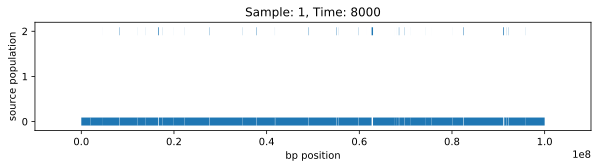

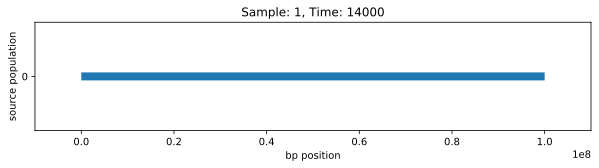

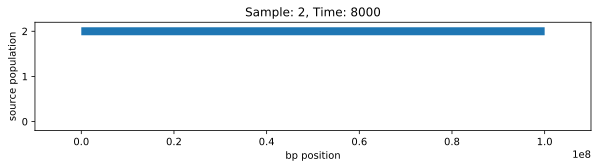

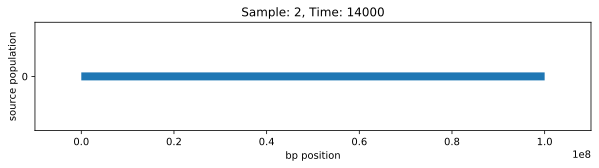

In [10]:
for sample in [1,2]:
    for time in [8000, 14000]:
        la = find_local_ancestry(sample = sample, time = time, ts=ts)
        plot_merged_segments(la)
        plt.title('Sample: {}, Time: {}'.format(sample, time))

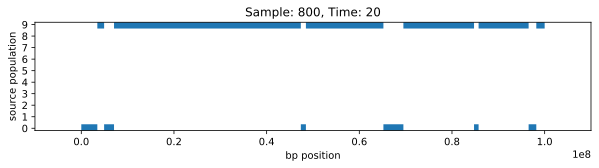

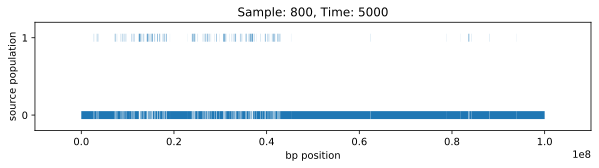

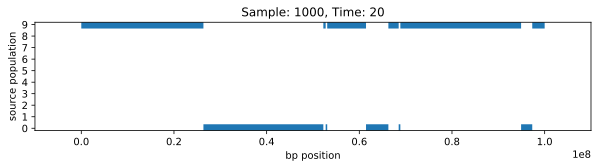

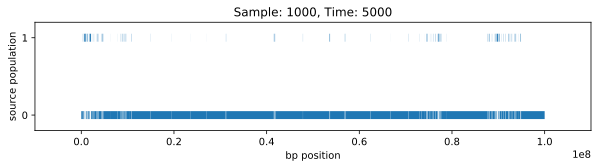

In [14]:
# try 2 admixed pop
for sample in [800,1000]:
    for time in [20, 5000]:
        la = find_local_ancestry(sample = sample, time = time, ts=treeseq)
        plot_merged_segments(la)
        plt.title('Sample: {}, Time: {}'.format(sample, time))

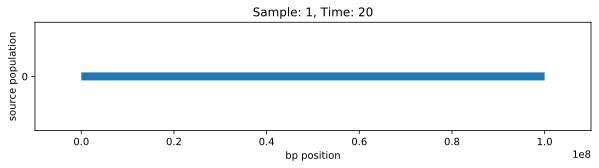

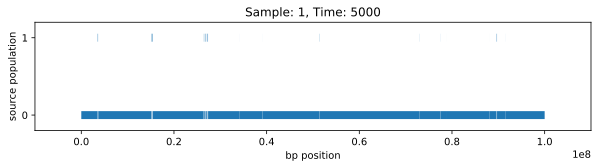

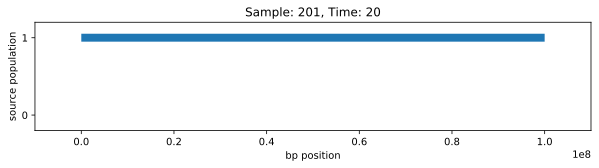

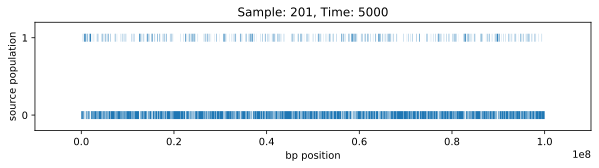

In [15]:
# try AFR and EUR
for sample in [1,201]:
    for time in [20, 5000]:
        la = find_local_ancestry(sample = sample, time = time, ts=treeseq)
        plot_merged_segments(la)
        plt.title('Sample: {}, Time: {}'.format(sample, time))

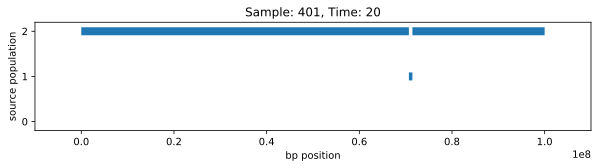

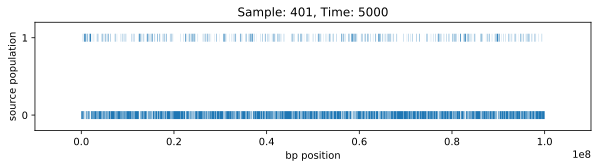

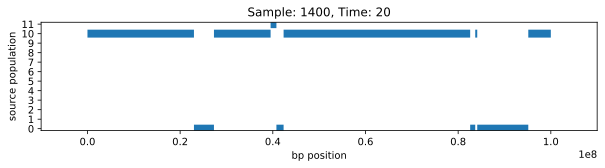

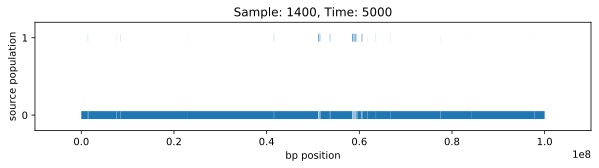

In [16]:
# try 2 admixed pop with more EUR anc and AFR anc
for sample in [401,1400]:
    for time in [20, 5000]:
        la = find_local_ancestry(sample = sample, time = time, ts=treeseq)
        plot_merged_segments(la)
        plt.title('Sample: {}, Time: {}'.format(sample, time))